# BEARDS

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.chat
import common.live

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'

## Chat Daten

In [3]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

#create additional column
chat['day'] = chat.index.strftime('%Y-%m-%d')

## Live Daten
___

In [4]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')

## Auswertung 
___

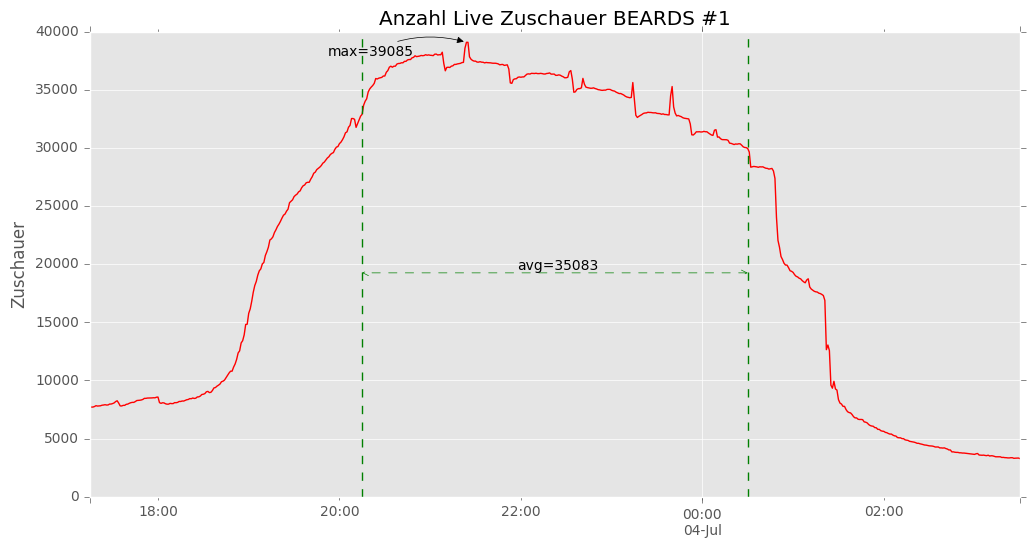

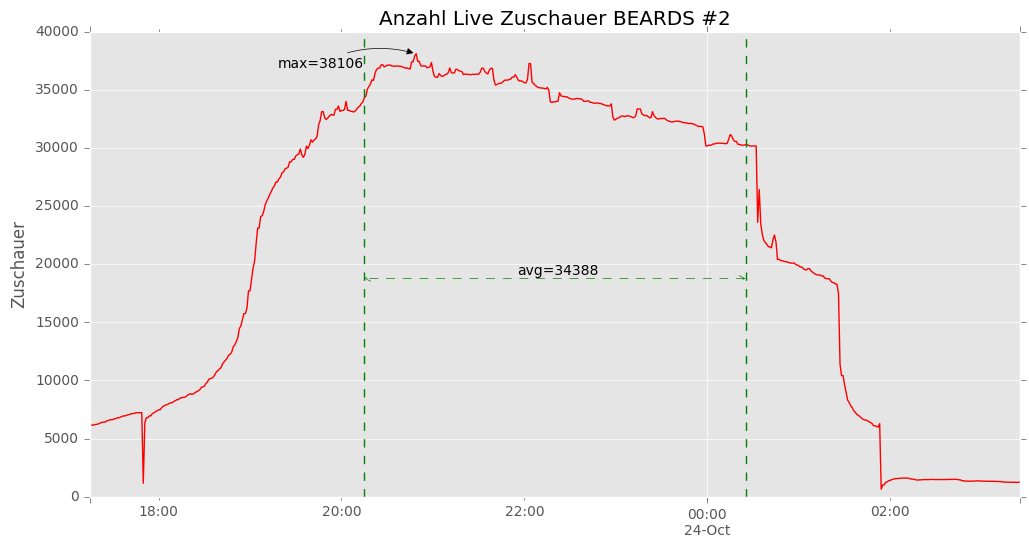

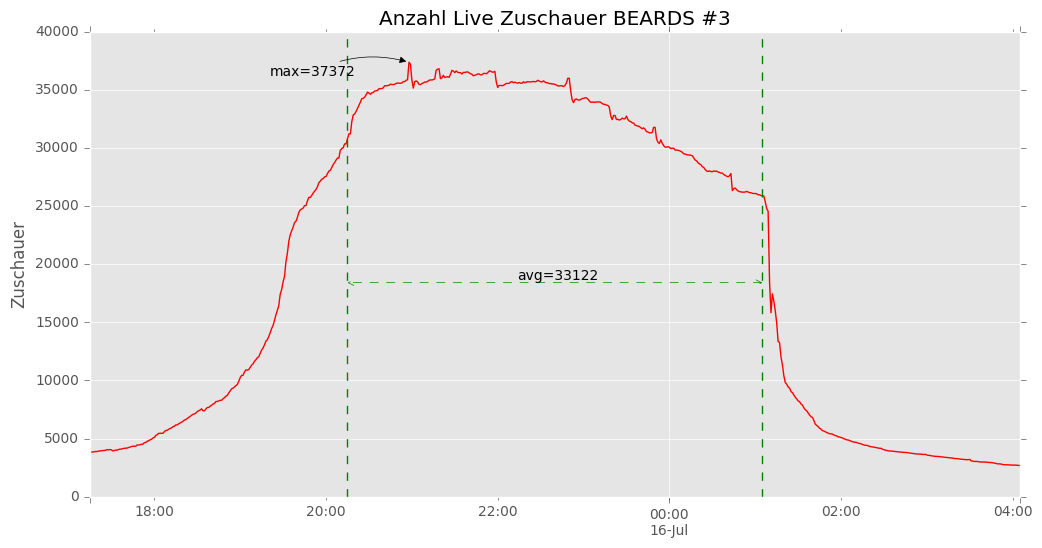

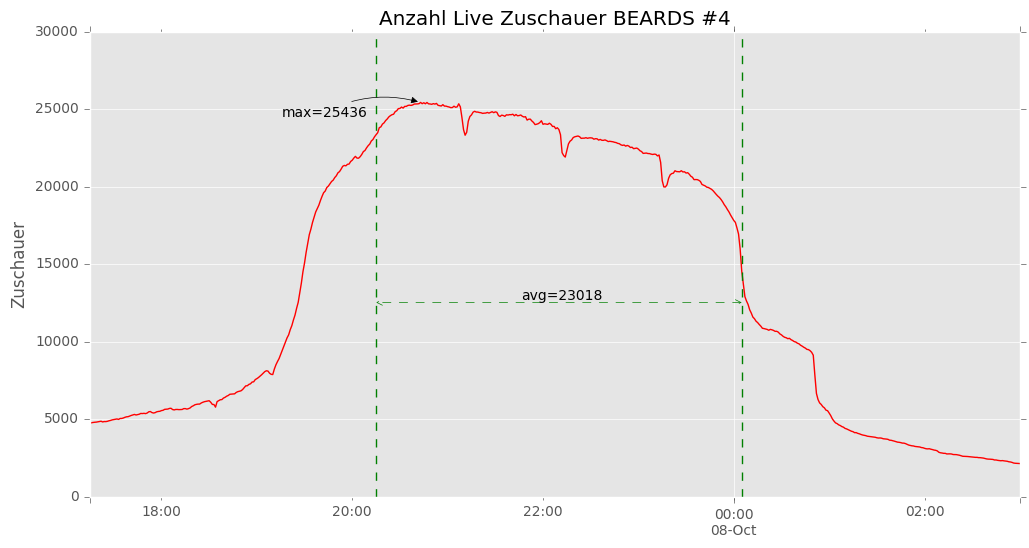

In [5]:
shows = [{
    'name': 'BEARDS #1',
    'start': datetime.datetime(2015, 7, 3, 20, 15, 0),
    'end': datetime.datetime(2015, 7, 4, 0, 30, 0)
}, {
    'name': 'BEARDS #2',
    'start': datetime.datetime(2015, 10, 23, 20, 15, 0),
    'end': datetime.datetime(2015, 10, 24, 0, 25, 0)
}, {
    'name': 'BEARDS #3',
    'start': datetime.datetime(2016, 7, 15, 20, 15, 0),
    'end': datetime.datetime(2016, 7, 16, 1, 5, 0)
}, {
    'name': 'BEARDS #4',
    'start': datetime.datetime(2016, 10, 7, 20, 15, 0),
    'end': datetime.datetime(2016, 10, 8, 0, 5, 0)
}]

margin = datetime.timedelta(hours=3)

for show in shows:
    #filter live data by date
    dateStart = show['start'] - margin
    dateEnd = show['end'] + margin
    liveFilteredMargin = live.loc[dateStart : dateEnd]

    #adjust column
    liveFilteredMargin = liveFilteredMargin['viewers'].to_frame('viewers')

    #filter live data by date
    liveFiltered = live.loc[show['start'] : show['end']]

    #adjust column
    liveFiltered = liveFiltered['viewers'].to_frame('viewers')

    #plot
    plot = liveFilteredMargin.plot(figsize=(12, 6), color='r', legend=False, title='Anzahl Live Zuschauer %s' % show['name'])
    plot.set_xlabel('')
    plot.set_ylabel('Zuschauer')

    plt.ylim(ymin=0)

    #annotate max
    datapointMax = {
        'x': liveFiltered.idxmax()[0],
        'y': liveFiltered.max()[0]
    }
    plot.annotate('max=%d' % datapointMax['y'], 
                  xy=(datapointMax['x'], datapointMax['y']), xycoords='data', 
                  xytext=(-100, -10), textcoords='offset points',
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle='arc3,rad=-0.2',
                                  linewidth = 0.5,
                                  color = 'black')
                 )

    #annotate avg
    dateMiddle = (show['start'] + (show['end'] - show['start']) / 2)
    plot.annotate('', 
                  xy=(show['start'], datapointMax['y'] / 2.03), xycoords='data', 
                  xytext=(show['end'], datapointMax['y'] / 2.03), textcoords='data',
                  arrowprops=dict(edgecolor='g', arrowstyle = '<->', linestyle='--', shrinkA=0, shrinkB=0)
                  )
    plot.annotate('avg=%d' % liveFiltered.mean(), 
                  xy=(dateMiddle, datapointMax['y'] / 2), xycoords='data', 
                  xytext=(-27, 0), textcoords='offset points')

    #start/end times
    plot.axvline(show['start'], color='g', linestyle='--')
    plot.axvline(show['end'], color='g', linestyle='--')

plot

In [6]:
data = pd.DataFrame(columns=('messages', 'participants', 'ratio'))

for show in shows:
    #filter live data by date
    liveFiltered = live.loc[show['start'] : show['end']]

    #adjust column
    liveFiltered = liveFiltered['viewers'].to_frame('viewers')

    #filter chat data by date
    chatFiltered = chat.loc[show['start'] : show['end']]

    #message count
    chatMessages = len(chatFiltered)

    #count (unique) users
    chatParticipants = len(chatFiltered['username'].unique())
    
    #participants to viewers ratio
    ratio = chatParticipants / liveFiltered.mean()

    data.loc[show['name']] = (chatMessages, chatParticipants, ratio)

data

,messages,participants,ratio
BEARDS #1,0.0,0.0,0.000000
BEARDS #2,48157.0,11475.0,0.333684
BEARDS #3,97024.0,11899.0,0.359246
BEARDS #4,30609.0,6657.0,0.289201


(0, 100000.0)

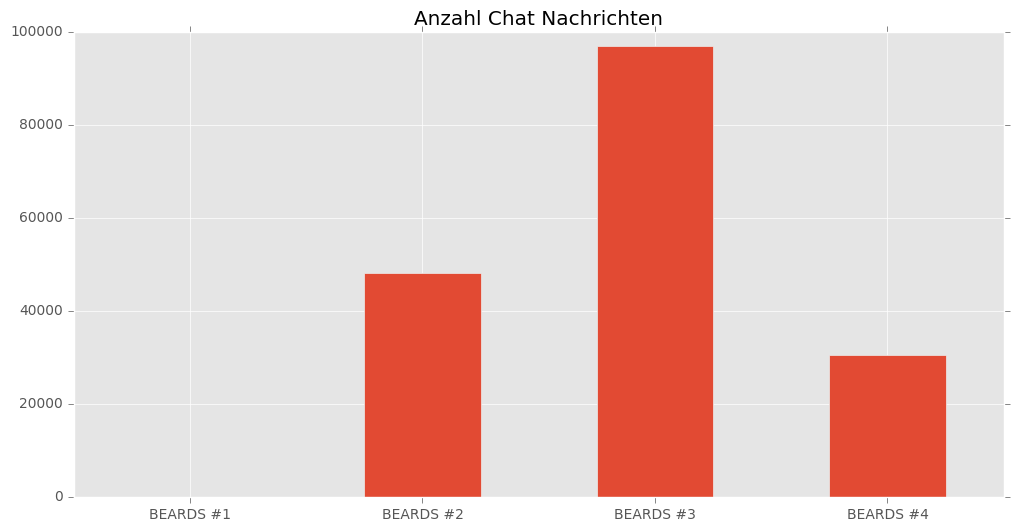

In [7]:
plot = data['messages'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Nachrichten')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 12000.0)

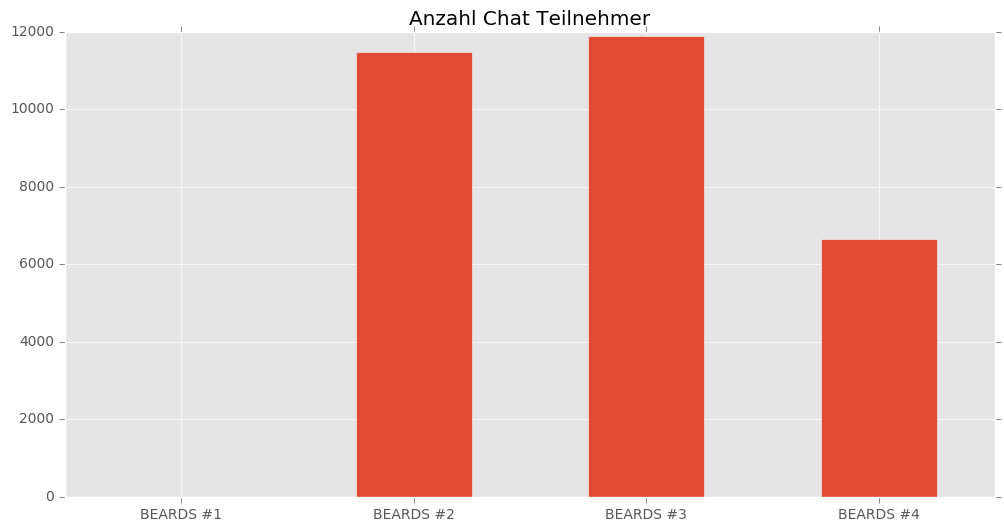

In [8]:
plot = data['participants'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Teilnehmer')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 0.40000000000000002)

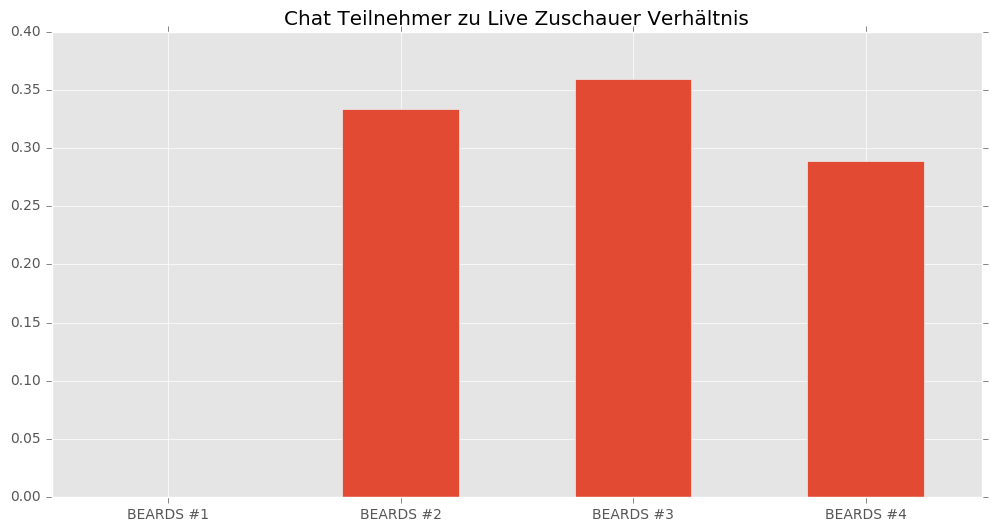

In [9]:
plot = data['ratio'].plot(kind='bar', figsize=(12, 6), title='Chat Teilnehmer zu Live Zuschauer Verhältnis')

plt.xticks(rotation=0)
plt.ylim(ymin=0)